In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix

### Reading and exploring the data

In [2]:
df = pd.read_excel('Acoustic_Extinguisher_Fire_Dataset.xlsx')

In [3]:
df.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  object 
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   STATUS     17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB


In [5]:
df['STATUS'] = df['STATUS'].astype('category')
df['FUEL'] = df['FUEL'].astype('category')

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SIZE,17442.0,3.411765,1.750977,1.0,2.0,3.0,5.0,7.0
DISTANCE,17442.0,100.000000,54.773826,10.0,50.0,100.0,150.0,190.0
DESIBEL,17442.0,96.379142,8.164096,72.0,90.0,95.0,104.0,113.0
AIRFLOW,17442.0,6.975634,4.736169,0.0,3.2,5.8,11.2,17.0
FREQUENCY,17442.0,31.611111,20.939149,1.0,14.0,27.5,47.0,75.0


In [7]:
def plot_histogram(df):
    fig,axes = plt.subplots(3,2,figsize=(9,12),dpi=200)
    for ax, col in zip(axes.flatten(), df.columns):
        sns.histplot(x=df[col],kde=True,element='step',ax=ax)

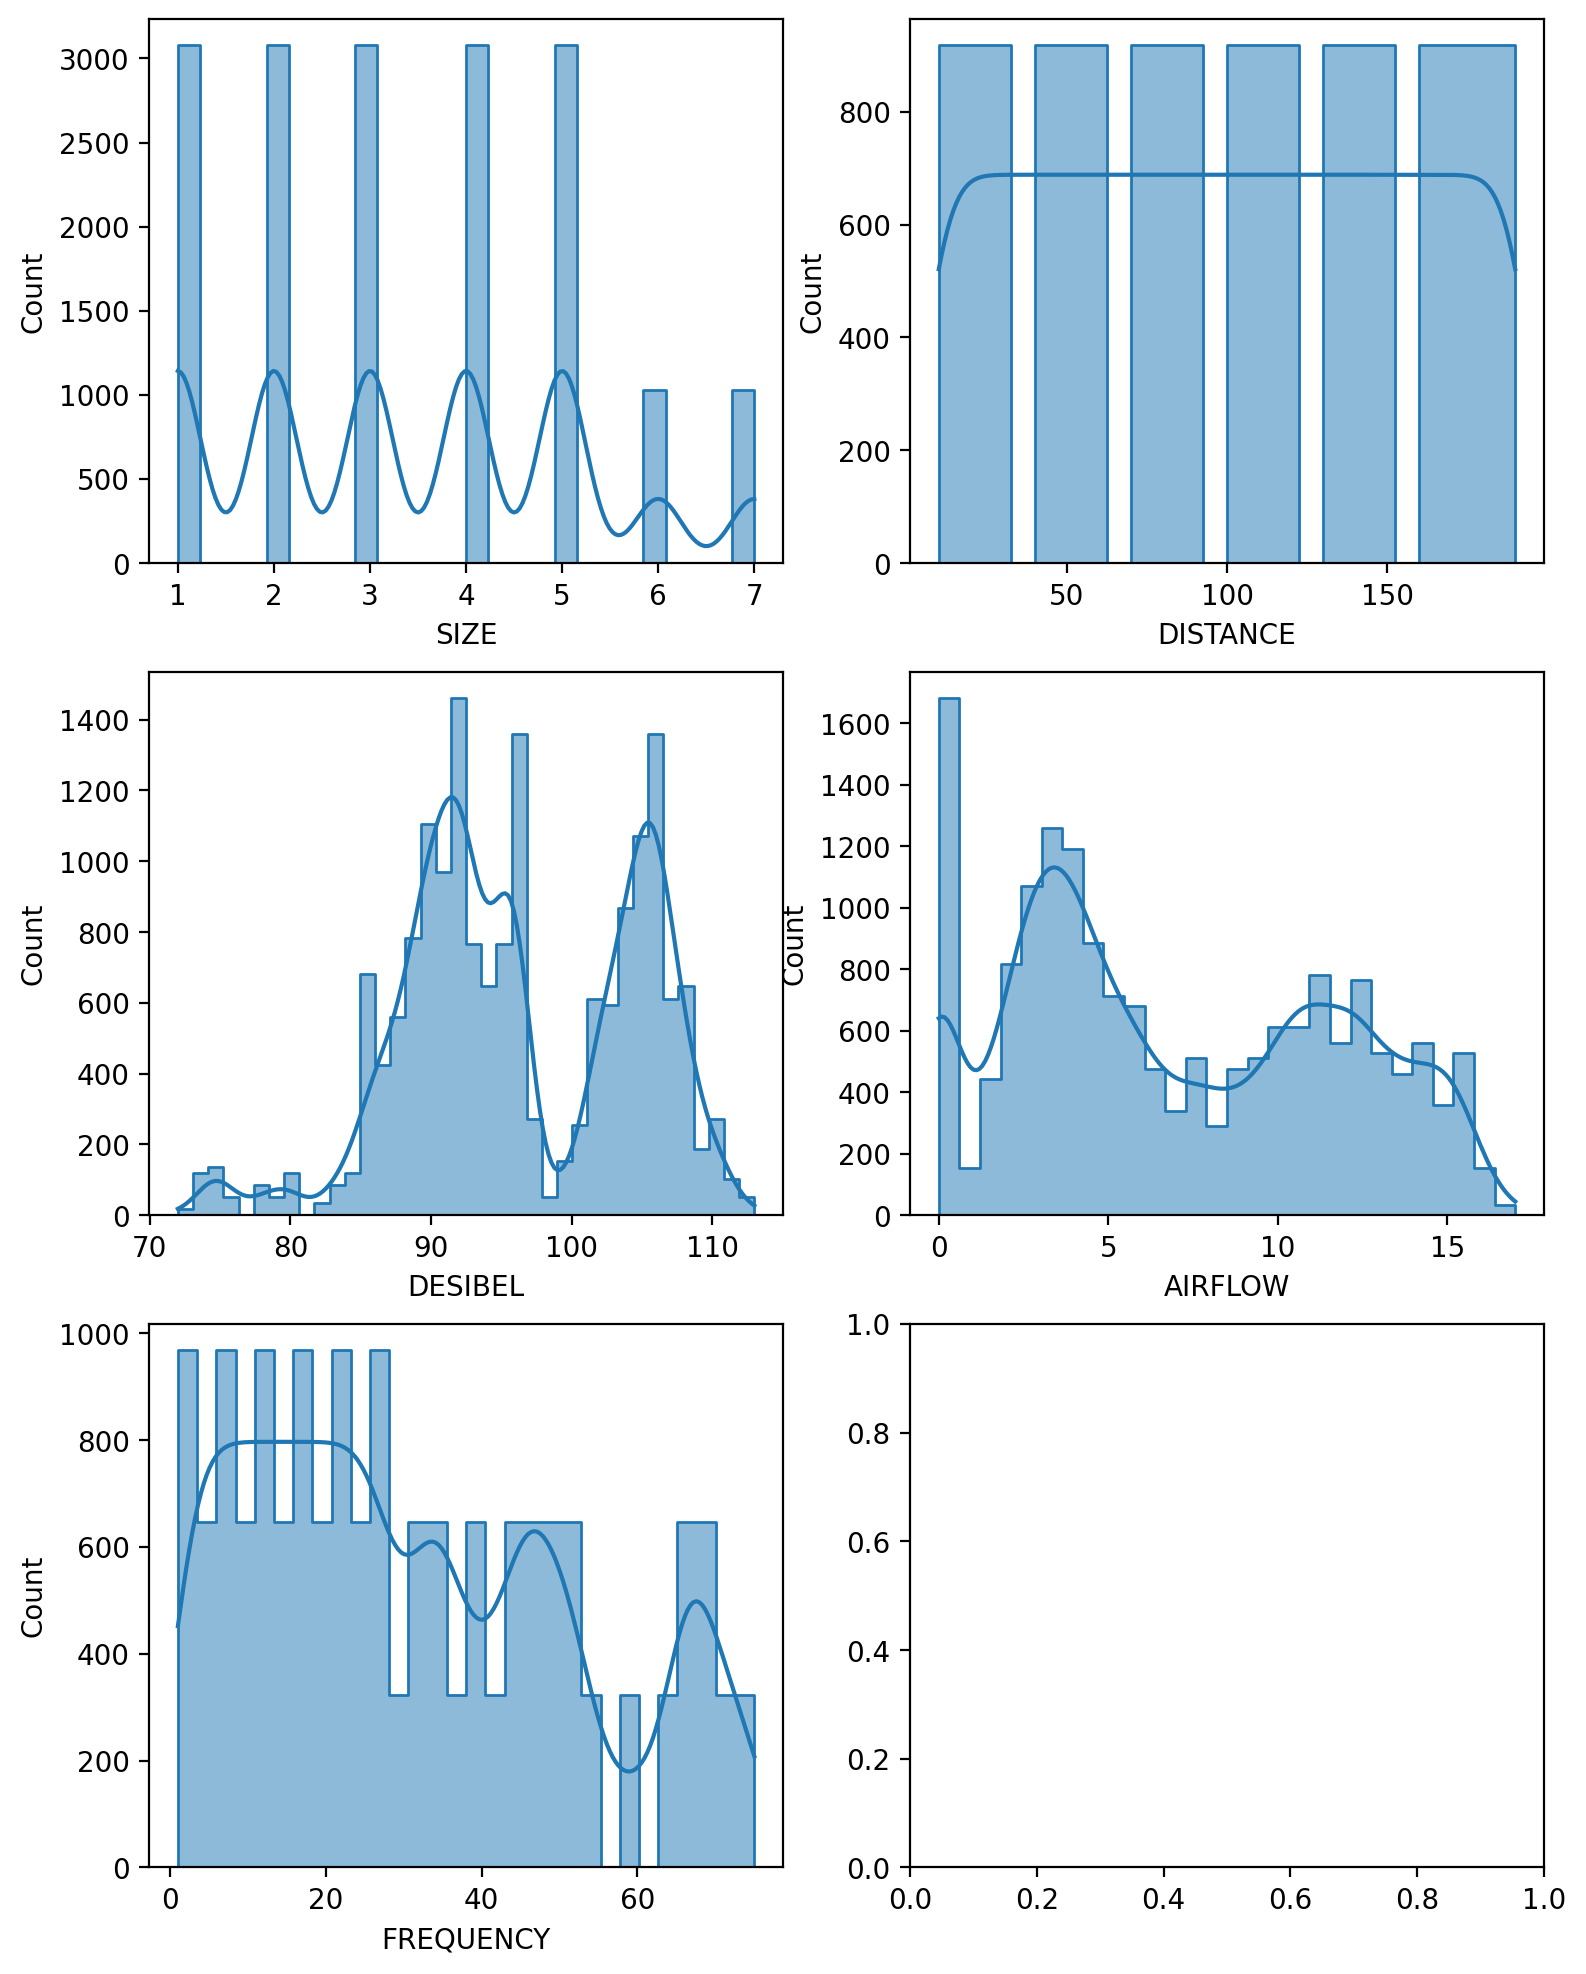

In [8]:
plot_histogram(df.select_dtypes(['int64','float64']))

Data is not normally distributed. There are many clusters.

<Figure size 960x720 with 0 Axes>

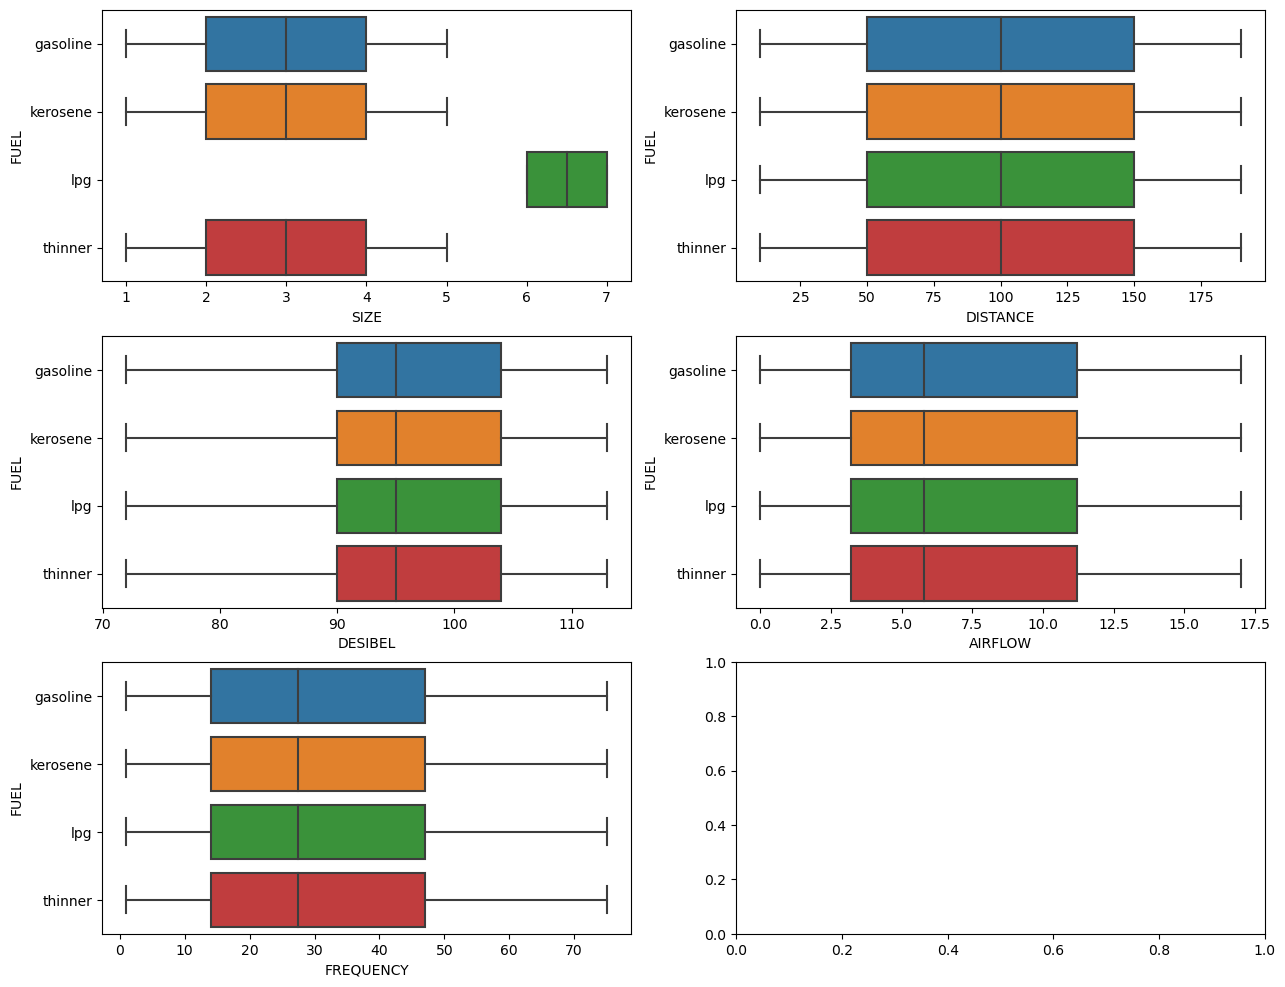

In [9]:
plt.figure(dpi=150)

fig, axes = plt.subplots(3,2,figsize=(15,12))

for ax, col in zip(axes.flatten(), ['SIZE', 'DISTANCE', 'DESIBEL', 'AIRFLOW', 'FREQUENCY']):
    sns.boxplot(x = df[col], y = df['FUEL'], ax=ax)

There are no outliers.

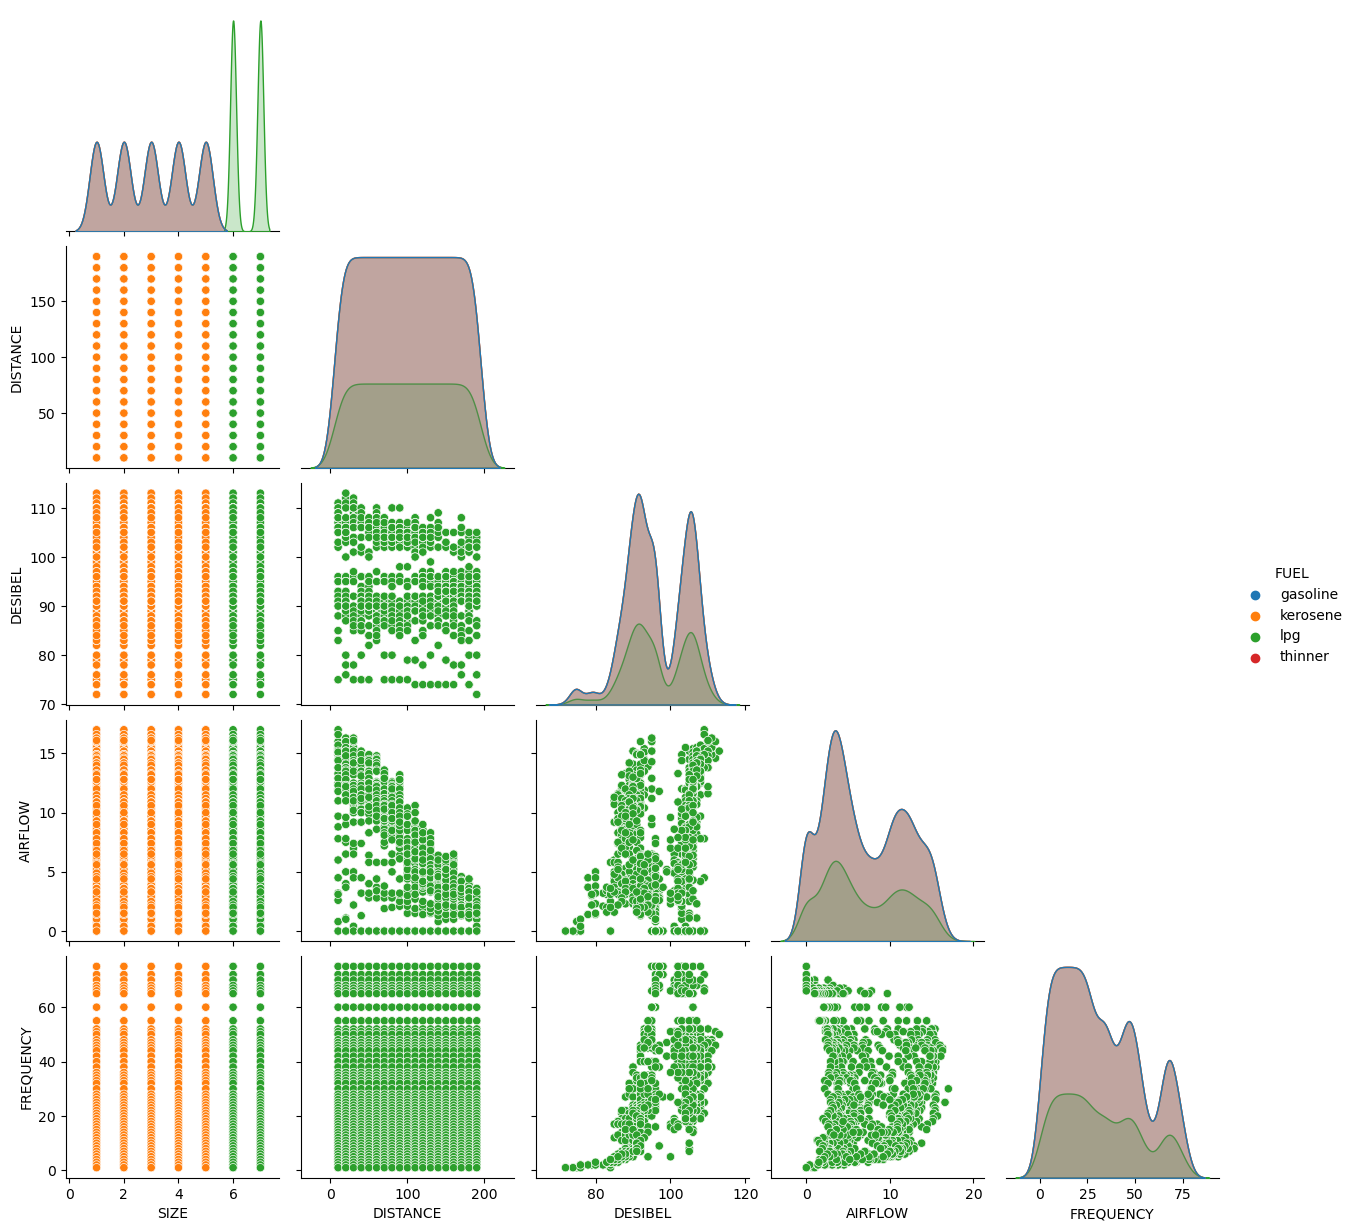

In [10]:
sns.pairplot(df,hue='FUEL',diag_kind='kde',corner=True)

It appears that there are many overlapping values in the dataset corresponding to fuel type. It is therefore very difficult to classify based on fuel type. Hence, dropping FUEL feature will not affect the classification.

In [11]:
df = df.drop('FUEL',axis=1)

**Splitting data into independent and dependent features**

In [12]:
X = df.drop('STATUS',axis=1)
y = df['STATUS']

In [13]:
y.value_counts()

0    8759
1    8683
Name: STATUS, dtype: int64

This is a fairly balanced dataset.

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.25,shuffle=True, random_state=1)

In [15]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [16]:
def cv(X_train,y_train):
    models = [RandomForestClassifier(random_state=1),
              KNeighborsClassifier(), 
              SVC(random_state=1), 
              XGBClassifier(random_state=1)]
    for mod in models:
        model = cross_validate(mod, X_train, y_train, cv=10)
        print('Accuracy of ',mod,': %.3f'%model['test_score'].mean())

In [17]:
cv(X_train_scaled,y_train)

Accuracy of  RandomForestClassifier(random_state=1) : 0.913
Accuracy of  KNeighborsClassifier() : 0.929
Accuracy of  SVC(random_state=1) : 0.924
Accuracy of  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1,
              reg_alpha=None, reg_lambda=None, ...) : 0.930


**The best model on training data is XGB Classifier**

Accuracy Score of train data = 0.954
Accuracy Score of test data  = 0.939

 Classification Report for Test Data 

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2190
           1       0.94      0.93      0.94      2171

    accuracy                           0.94      4361
   macro avg       0.94      0.94      0.94      4361
weighted avg       0.94      0.94      0.94      4361



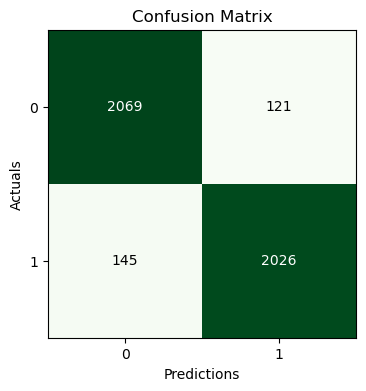

In [18]:
model = XGBClassifier(random_state=1)
model.fit(X_train_scaled,y_train)

print('Accuracy Score of train data = %0.3f'%model.score(X_train_scaled,y_train))
print('Accuracy Score of test data  = %0.3f'%model.score(X_test_scaled,y_test))
    

y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)
cm = metrics.confusion_matrix(y_test,y_pred)
    
print('\n Classification Report for Test Data \n')
print(metrics.classification_report(y_test, y_pred))

fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(4, 4),cmap='Greens',fontcolor_threshold=0.8)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

**Hyper-parameter tuning**

In [19]:
parameters = {    
    'n_estimators':[10,50,100,150,200,300,500],
    'max_depth': range(1,25),
    'learning_rate': [0.01,0.1,0.2],
}

search = RandomizedSearchCV(XGBClassifier(random_state=1),parameters,cv=10,random_state=1)

search.fit(X_train_scaled,y_train)

print(search.best_params_)

{'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.2}


Accuracy Score of train data = 0.950
Accuracy Score of test data  = 0.945

 Classification Report for Test Data 

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2190
           1       0.95      0.94      0.94      2171

    accuracy                           0.94      4361
   macro avg       0.94      0.94      0.94      4361
weighted avg       0.94      0.94      0.94      4361



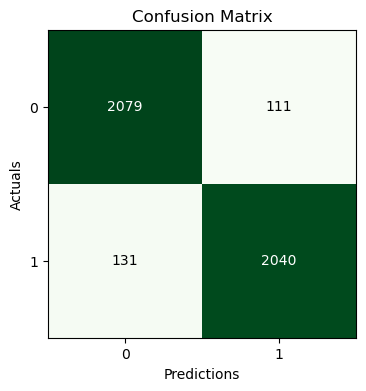

In [20]:
best_model = XGBClassifier(n_estimators=150,
                           max_depth=4,learning_rate=0.2,
                           random_state=1)

best_model.fit(X_train_scaled,y_train)

print('Accuracy Score of train data = %0.3f'%best_model.score(X_train_scaled,y_train))
print('Accuracy Score of test data  = %0.3f'%best_model.score(X_test_scaled,y_test))
    

y_pred = best_model.predict(X_test_scaled)
y_pred_train = best_model.predict(X_train_scaled)
cm = metrics.confusion_matrix(y_test,y_pred)
    
print('\n Classification Report for Test Data \n')
print(metrics.classification_report(y_test, y_pred))

fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(4, 4),cmap='Greens',fontcolor_threshold=0.8)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()